# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

__Your main objective: to develop an automated method to pinpoint the times of fault and failure in this machine__.  Keep in mind that you will be sharing these results with the executives at ExampleCo, so to the best of your ability, try to explain what you are doing, what you've shown, and why you think your predictions are good.


A few notes to help:
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like. Your final results should be
   presented in this Python notebook.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted. In particular you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

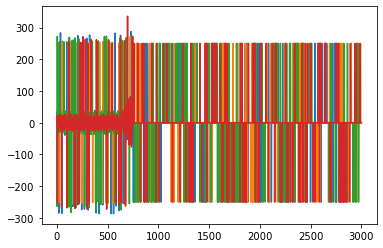

In [63]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np


data = pd.read_csv('../input/challenge/exampleco_data/machine_9.csv',index_col=0)

plt.plot(range(len(data)), data)
plt.show()

In [64]:
# Import required packages\
from matplotlib.dates import DateFormatter,YearLocator,MonthLocator
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import copy
import seaborn as sns
from scipy import stats
import matplotlib.dates as mdates



## Exploring the data

Let's focus on Machine number 9 for now. I have selected the machine randomly. Let's have a look at the distribution of the signals from machine 9.

In [65]:
data.describe()

,0,1,2,3
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,-0.202280,0.538858,-0.917428,0.113986
std,57.262530,55.876419,57.242910,56.702635
min,-287.466691,-263.865377,-283.124460,-272.446864
25%,-0.010198,-0.010268,-0.011170,-0.010604
50%,-0.000078,-0.000073,-0.000612,0.000009
75%,0.010965,0.010909,0.010096,0.010871
max,287.127760,271.252746,273.416352,335.666860


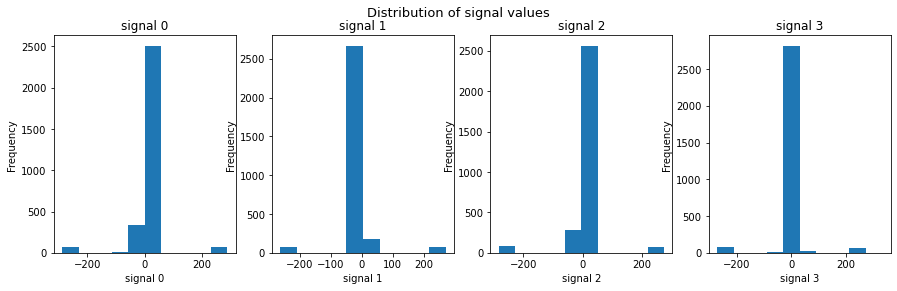

In [66]:
fig,((ax1, ax2,ax3, ax4)) = plt.subplots(1, 4,figsize=(15,4))
ax1.hist(data.iloc[:,0])
ax1.set(title='signal 0',xlabel='signal 0',ylabel='Frequency')
ax2.hist(data.iloc[:,1])
ax2.set(title='signal 1',xlabel='signal 1',ylabel='Frequency')
ax3.hist(data.iloc[:,2])
ax3.set(title='signal 2',xlabel='signal 2',ylabel='Frequency')
ax4.hist(data.iloc[:,3])
ax4.set(title='signal 3',xlabel='signal 3',ylabel='Frequency')
fig.suptitle('Distribution of signal values',fontsize=13)
plt.show()


From the plots it can be seen that majority of the signals have value around 0. And many high values of magnitude 200+. Which seem like they are due to measurement error of the signals.

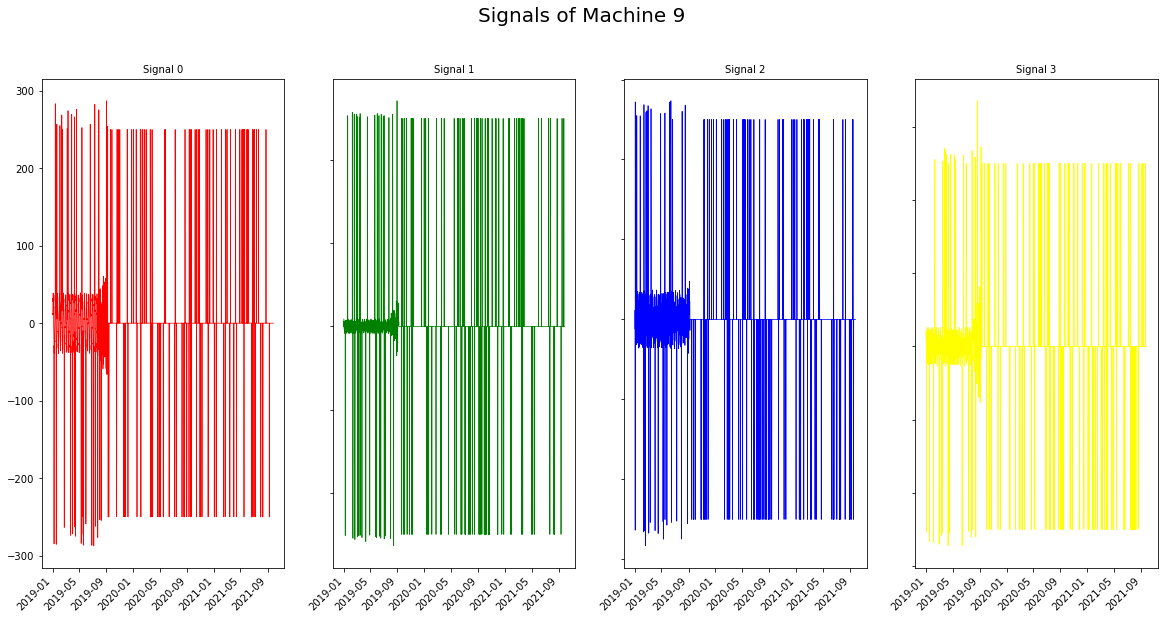

In [67]:
#fig,ax = plt.subplots(),
dates= pd.to_datetime(data.index)
fig,((ax1, ax2,ax3, ax4)) = plt.subplots(1, 4,figsize=(20,10))
ax1.plot(dates,data['0'],label='0th',color= 'red', animated=True,linewidth=0.75)
ax1.set_title('Signal 0',fontsize=10)
ax2.plot(dates,data['1'],label='1th',color= 'green', animated=True,linewidth=0.75)
ax2.set_title('Signal 1',fontsize=10)
ax3.plot(dates,data['2'],label='2th',color= 'blue', animated=True,linewidth=0.75)
ax3.set_title('Signal 2',fontsize=10)
ax4.plot(dates,data['3'],label='3th',color= 'yellow', animated=True,linewidth=0.75)
ax4.set_title('Signal 3',fontsize=10)

fig. autofmt_xdate(rotation= 45)

fig.suptitle('Signals of Machine 9',fontsize=20)
for ax in fig.get_axes():    
    #plt.legend(loc='lower right')
    #ax.set_title('Training Set',fontsize=20)
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
    ax.label_outer()

We are not able to observe the signals easily due to outliers present in the data. These outliers can be removed manually by removing signal values which are unexpectedly large (200+). Otherwise we can remove them using Z-score approach. We will remove all the data points which have Z-score higher than 3. These are the points (0.03% of signal points) which are away from the central value of the signal. 

### Removing Outliers

In [68]:
def remove_outliers(data,threshold=3):
    #compute z score
    z = np.abs(stats.zscore(data))
    #remove data points with z score greater than the threshold 
    data_z= data[(z < threshold).all(axis=1)]
    return data_z
    

In [69]:
data_z= remove_outliers(data)

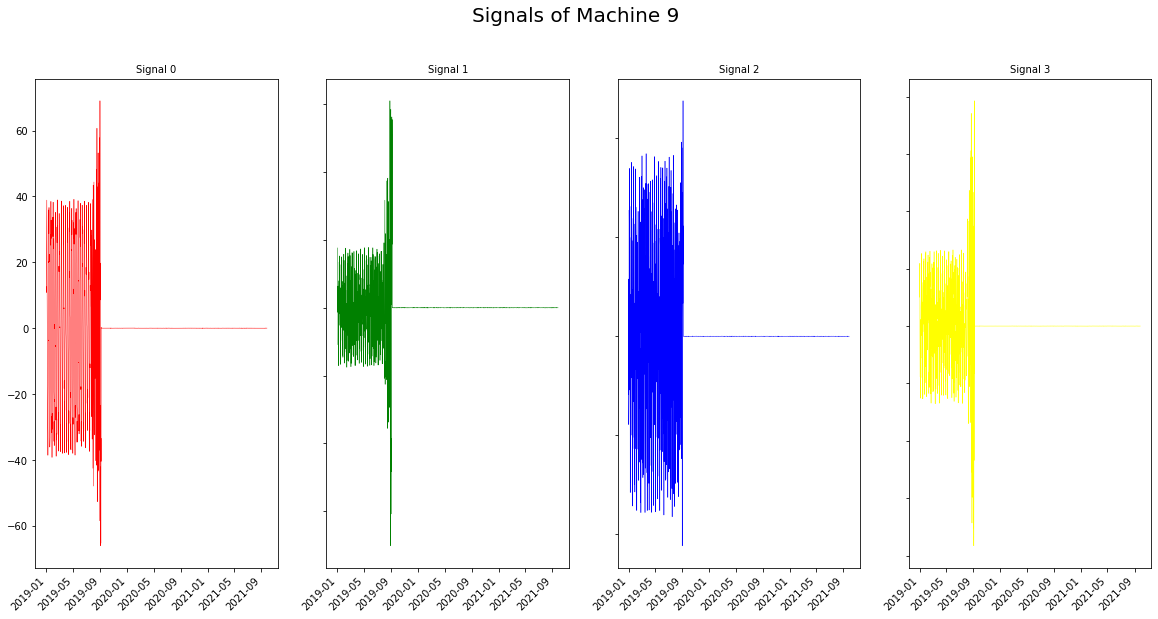

In [70]:
#fig,ax = plt.subplots(),
dates= pd.to_datetime(data_z.index)
fig,((ax1, ax2,ax3, ax4)) = plt.subplots(1, 4,figsize=(20,10))
ax1.plot(dates,data_z['0'],label='0th',color= 'red', animated=True,linewidth=0.5)
ax1.set_title('Signal 0',fontsize=10)
ax2.plot(dates,data_z['1'],label='1th',color= 'green', animated=True,linewidth=0.5)
ax2.set_title('Signal 1',fontsize=10)
ax3.plot(dates,data_z['2'],label='2th',color= 'blue', animated=True,linewidth=0.5)
ax3.set_title('Signal 2',fontsize=10)
ax4.plot(dates,data_z['3'],label='3th',color= 'yellow', animated=True,linewidth=0.5)
ax4.set_title('Signal 3',fontsize=10)

fig. autofmt_xdate(rotation= 45)

fig.suptitle('Signals of Machine 9',fontsize=20)
for ax in fig.get_axes():    
    #plt.legend(loc='lower right')
    #ax.set_title('Training Set',fontsize=20)
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
    ax.label_outer()

Now, we can observe the data in a meaningful way. As we have removed the outliers which have no effect on the results of the problem. 

In [71]:
data_z.describe()

,0,1,2,3
count,2441.000000,2441.000000,2441.000000,2441.000000
mean,0.060071,0.045048,0.201552,0.243929
std,12.864975,3.458906,9.361144,8.973323
min,-66.135371,-35.113970,-42.321600,-76.605562
25%,-0.009859,-0.009438,-0.009888,-0.009621
50%,-0.000202,0.000042,-0.000482,0.000050
75%,0.010425,0.010232,0.009778,0.010261
max,69.078712,30.527982,47.545806,78.522482


## Finding faulty dates and failure dates

#### From the graphs and the data it is visible that there are three stages as defined by the problem: normal, faulty and failed respectively.
- At the normal stage signals from the machine are periodic and  almost constant in amplitude. 
- At the faulty stage signals from the machine are not so periodic and varying highly in amplitude. 
- At the failed stage signals from the machine are almost equal to 0.


### Detecting the failure stage:
#### Detection of failure stages is very easy we just have to detect when the signals from the machine are close to 0. 
#### Usign this information we can find the observations when the signals from the machine reaches 0 to determine the failure stage. 

In [72]:
def failure_dates(data_z):
    data_z.index= pd.to_datetime(data_z.index, format='%Y-%m-%d %H:%M:%S')
    failure_dates_list =data_z[(abs(data_z['0'])<0.1) & (abs(data_z['1'])<0.1) &(abs(data_z['2'])<0.1)&(abs(data_z['3'])<0.1)].index.tolist()
    
    print('First five failure stage dates: ', failure_dates_list[:5])
    return failure_dates_list
    

In [73]:
# Finding out the times of failure
times_of_failure=failure_dates(data_z)

First five failure stage dates:  [Timestamp('2019-09-07 09:59:43.194398132'), Timestamp('2019-09-07 17:59:52.797599200'), Timestamp('2019-09-08 02:00:02.400800268'), Timestamp('2019-09-08 10:00:12.004001336'), Timestamp('2019-09-08 18:00:21.607202400')]


By looking at the list, **times_of_failure**, we can understand when the machine was at failed stage. 

### Detecting the faulty stage:
#### Detection of beginning faulty stage is more difficult task compre to the detection of the failure stage. Let's observe how the signals from the machine behaves before it enters in the failed stage, i.e. how the signals are in normal and faulty mode.

In [74]:
data_z.tail(15)

,0,1,2,3
2021-09-21 15:57:26.348782928,-0.006601,0.010814,-0.000482,-0.006528
2021-09-22 07:57:45.555185072,-0.005820,-0.012442,0.002196,-0.013837
2021-09-22 15:57:55.158386128,0.003643,-0.000741,0.008622,0.000705
2021-09-22 23:58:04.761587200,-0.003990,-0.001933,-0.000542,0.003330
2021-09-23 07:58:14.364788272,-0.012493,-0.004396,-0.008726,0.004566
2021-09-23 15:58:23.967989328,0.005363,0.012119,-0.015792,-0.006609
2021-09-23 23:58:33.571190400,0.002102,0.004805,-0.002373,0.002654
2021-09-24 15:58:52.777592528,-0.001374,0.004388,-0.009496,-0.006114
2021-09-24 23:59:02.380793600,-0.017372,0.002685,0.004917,-0.007404
2021-09-25 07:59:11.983994672,-0.001263,-0.018177,0.007230,-0.000608


According to the problem description and by also observing the tail of the data and graph revealed that at the failed stage the signals are almost close to 0 and always lower than absolute value of 0.1.
Hence removing the faulty stage based on above mentioned observations.

In [75]:
data_final =data_z[(abs(data_z['0'])>0.1) & (abs(data_z['1'])>0.1) &(abs(data_z['2'])>0.1)&(abs(data_z['3'])>0.1)]
data_final.index= pd.to_datetime(data_final.index, format='%Y-%m-%d %H:%M:%S')

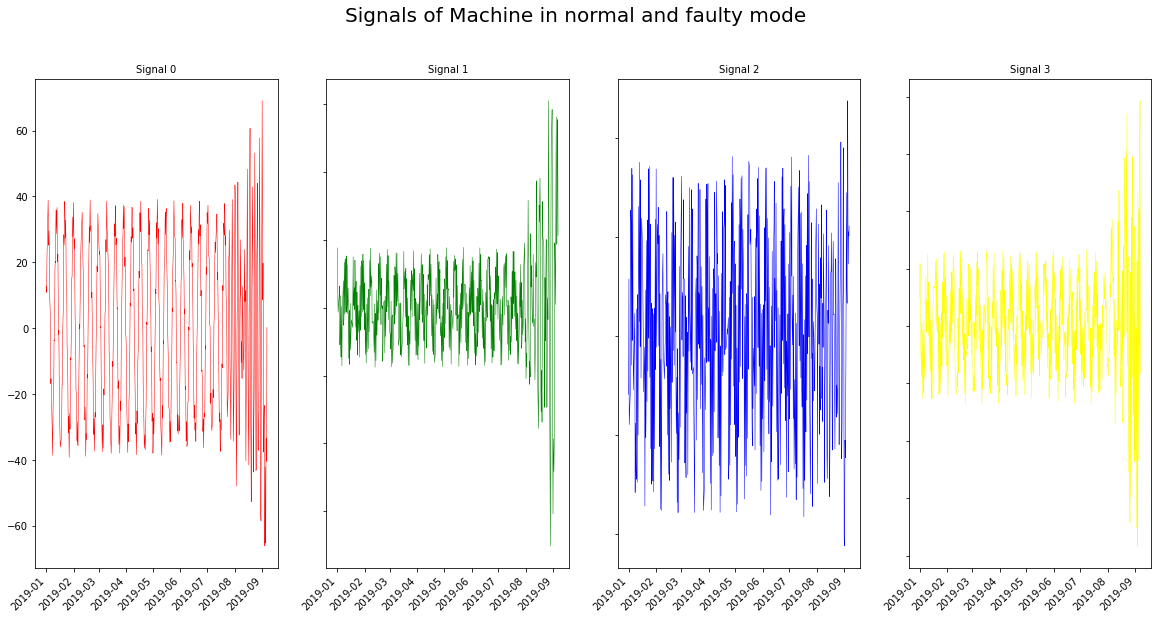

In [76]:
import matplotlib.dates as mdates
dates= pd.to_datetime(data_final.index)
fig,((ax1, ax2,ax3, ax4)) = plt.subplots(1, 4,figsize=(20,10))
ax1.plot(dates,data_final['0'],label='0th',color= 'red', animated=True,linewidth=0.5)
ax1.set_title('Signal 0',fontsize=10)
ax2.plot(dates,data_final['1'],label='1th',color= 'green', animated=True,linewidth=0.5)
ax2.set_title('Signal 1',fontsize=10)
ax3.plot(dates,data_final['2'],label='2th',color= 'blue', animated=True,linewidth=0.5)
ax3.set_title('Signal 2',fontsize=10)
ax4.plot(dates,data_final['3'],label='3th',color= 'yellow', animated=True,linewidth=0.5)
ax4.set_title('Signal 3',fontsize=10)

fig.autofmt_xdate(rotation= 45)

fig.suptitle('Signals of Machine in normal and faulty mode',fontsize=20)
for ax in fig.get_axes():    
    #plt.legend(loc='lower right')
    #ax.set_title('Training Set',fontsize=20)
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
    ax.label_outer()

From the graphs it is clear that there exist a faulty stage before the failed stage which is different that the normal stage of operation. This problem of detecting the faulty stage now could be solved using various technqiues. 

1. Autoencoders based approach with anomalies detection
2. Classification based approach
3. Time Series based approach 
<br/>

#### (1) Autoencoders based approach with anomalies detection.
It works on assumption that the signals from the faulty stage are different(anomalous) from the normal mode of operation. It is unsupervised learning problem, Input for the autoencoder will be signal values. The autoencoder is made up of encoder-decoder pair. The encoder takes the signal as input which then encodes the signal informtion in simpler form at bottleneck and then decoder tries to reconstruct the input form those extracted features at bottleneck. <br/>
We are not intesrested in the output but the differnece in input and output(reconstruction error) of the autoencoder. 
We will be training the autoencoder model using the normal stage signals. It will learn to reconsturct the normal stage signals with low error. But when we input signals which are anomalous (such as faulty stage signals) the model will fail to reconstruct the signal giving rise to higher error when compared to the normal stage reconstruction error. 
     


![image](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
[image source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)

We will observe the histogram of reconstruction error for normal stage and determine a threshold error, which will be used to find anomalous signal. If reconstruction error is above the threshold then the machine is in faulty stage.

We will split the data into train set and test set, train set consisting of normal stage signals and test set consisting some of the  normal stage to end of faulty stage signals.From the graphs above which is around **Jun-2019**

In [77]:

train_set = data_final[:'06-05-2019  01:00:01']
test_set = data_final['06-05-2019  01:00:01':]
print('shape of train set ',train_set.shape)
print('shape of test set ',test_set.shape)

shape of train set  (363, 4)
shape of test set  (232, 4)


Saving the notebook on jovian platform

In [109]:
!pip install jovian --upgrade --quiet
import jovian
jovian.commit(project='data-science-exercise-Final', environment=None)

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/adesh-gadge/data-science-exercise-Final


<IPython.core.display.Javascript object>

Performing scaling operation on the signal to bring them between range of 0 and 1 which is suitable input for the autoencoder neural network.

In [78]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

Reshaping the data as required by the autoencoder input as LSTM cells expect a 3 dimensional tensor of the form [data samples, time steps, features]

In [79]:
def reshaped(X):
    return X.reshape(X.shape[0],1,X.shape[1])

X_train = reshaped(train_scaled)
print('Training data shape',X_train.shape)
X_test = reshaped(test_scaled)
print('Testing data shape',X_test.shape)

Training data shape (363, 1, 4)
Testing data shape (232, 1, 4)


In [80]:
from numpy.random import seed
import tensorflow as tf

from keras.layers import Input,Dropout,Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
seed(10)


I have selected to use LSTM autoencoder, arbitrary choice LSTMs work better for non-linear time dependent data. Regular Dense autoencoder should also give rise to the similar results. 

In [81]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1],X.shape[2]))
    L1=LSTM(8,activation='relu',return_sequences =True,
           kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2=LSTM(4,activation='relu',return_sequences = False)(L1)
    L3= RepeatVector(X.shape[1])(L2)
    L4= LSTM(4,activation='relu',return_sequences = True)(L3)
    L5 = LSTM(8,activation='relu',return_sequences = True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [82]:
#uncomment when loading saved model
model_trained= tf.keras.models.load_model('../input/models/mymodel_machine_9.h5')
model = model_trained

Autoencoder was compiled using Adam as our neural network optimizer and mean absolute error was used for calculating our loss function

In [201]:
model = autoencoder_model(X_train)
model.compile(optimizer= 'adam', loss= 'mae')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 8)              416       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 8)              416       
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)              36    

In [27]:
# comment following lines if loading a trained model

nb_epochs= 200
batch_size= 10
history=  model.fit(X_train, X_train, epochs=nb_epochs, batch_size= batch_size, validation_split= 0.05).history

Epoch 1/200
35/35 [==============================] - 1s 24ms/step - loss: 0.4915 - val_loss: 0.4827
Epoch 2/200
35/35 [==============================] - 0s 5ms/step - loss: 0.4524 - val_loss: 0.4392
Epoch 3/200
35/35 [==============================] - 0s 5ms/step - loss: 0.4091 - val_loss: 0.3949
Epoch 4/200
35/35 [==============================] - 0s 5ms/step - loss: 0.3587 - val_loss: 0.3359
Epoch 5/200
35/35 [==============================] - 0s 5ms/step - loss: 0.2822 - val_loss: 0.2614
Epoch 6/200
35/35 [==============================] - 0s 5ms/step - loss: 0.2362 - val_loss: 0.2266
Epoch 7/200
35/35 [==============================] - 0s 5ms/step - loss: 0.2136 - val_loss: 0.2072
Epoch 8/200
35/35 [==============================] - 0s 5ms/step - loss: 0.2001 - val_loss: 0.1966
Epoch 9/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1940 - val_loss: 0.1926
Epoch 10/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1922 - val_loss: 0.1912
Epoch 11

35/35 [==============================] - 0s 5ms/step - loss: 0.1273 - val_loss: 0.1282
Epoch 84/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1271 - val_loss: 0.1273
Epoch 85/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1266 - val_loss: 0.1277
Epoch 86/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1262 - val_loss: 0.1264
Epoch 87/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1262 - val_loss: 0.1266
Epoch 88/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1253 - val_loss: 0.1251
Epoch 89/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1246 - val_loss: 0.1253
Epoch 90/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1243 - val_loss: 0.1238
Epoch 91/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1240 - val_loss: 0.1237
Epoch 92/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1236 - val_loss: 0.1231
Epoch 93/200


35/35 [==============================] - 0s 5ms/step - loss: 0.0976 - val_loss: 0.0917
Epoch 165/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0976 - val_loss: 0.0921
Epoch 166/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0974 - val_loss: 0.0920
Epoch 167/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0978 - val_loss: 0.0913
Epoch 168/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0974 - val_loss: 0.0915
Epoch 169/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0976 - val_loss: 0.0910
Epoch 170/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0976 - val_loss: 0.0923
Epoch 171/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0976 - val_loss: 0.0921
Epoch 172/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0971 - val_loss: 0.0911
Epoch 173/200
35/35 [==============================] - 0s 5ms/step - loss: 0.0971 - val_loss: 0.0908
Epoc

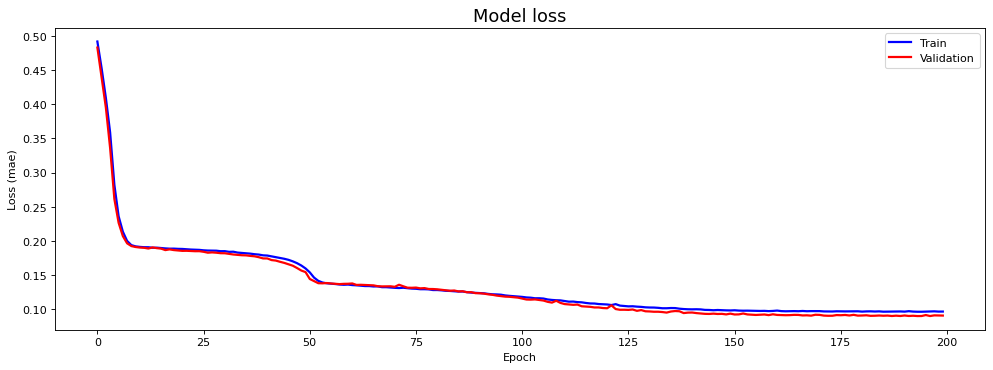

In [28]:
fig,ax = plt.subplots(figsize=(15,5),dpi=80)
ax.plot(history['loss'],'b',label = 'Train',linewidth=2)
ax.plot(history['val_loss'],'r',label= 'Validation', linewidth=2)
ax.set_title('Model loss',fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

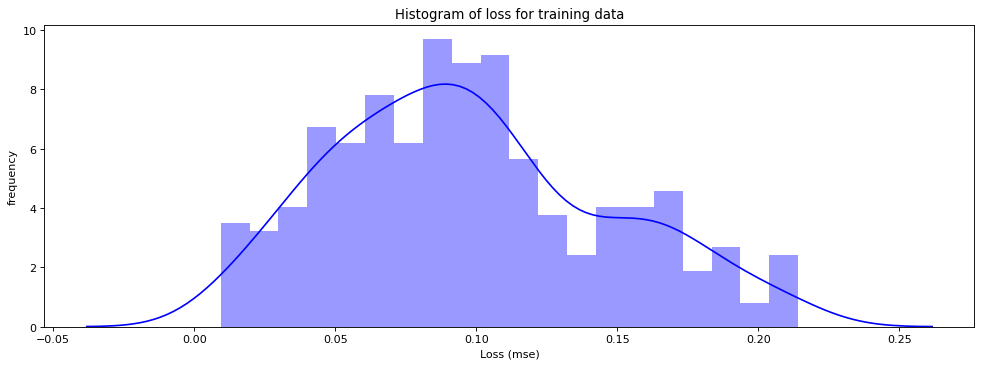

In [83]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0],X_pred.shape[2])
X_pred = pd.DataFrame(X_pred,columns=train_set.columns)
X_pred.index = train_set.index

scored= pd.DataFrame(index=train_set.index)
Xtrain= X_train.reshape(X_train.shape[0],X_train.shape[2])
scored['loss_mae']=np.mean(np.abs(X_pred-Xtrain),axis=1)
plt.figure(figsize=(15,5),dpi=80)
ax= sns.distplot(scored['loss_mae'],bins=20,kde=True,color='blue')
ax.set(xlabel='Loss (mse)', ylabel='frequency',title= 'Histogram of loss for training data')
plt.show()


Let's set threshold = 0.25, as most of the training data(normal signal) is being constructed with MSE error of 0.2
If the error is above 0.25 it is safe to assume the signal is Faulty

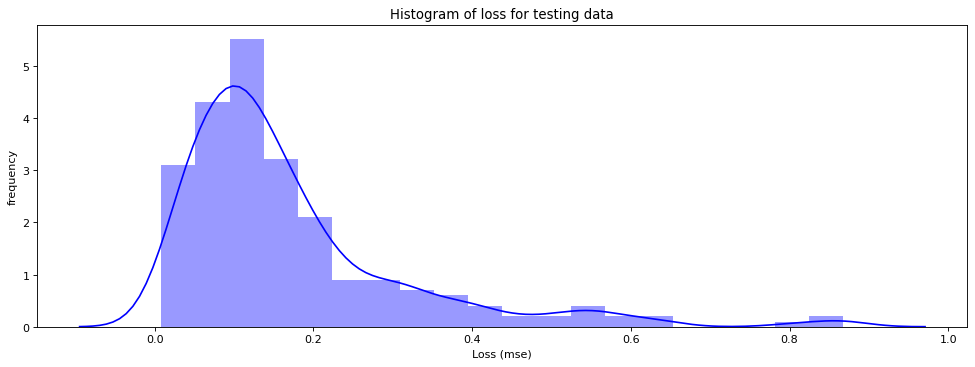

In [84]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0],X_pred.shape[2])
X_pred = pd.DataFrame(X_pred,columns=test_set.columns)
X_pred.index = test_set.index

scored= pd.DataFrame(index=test_set.index)
Xtest= X_test.reshape(X_test.shape[0],X_test.shape[2])
scored['loss_mae']=np.mean(np.abs(X_pred-Xtest),axis=1)
plt.figure(figsize=(15,5),dpi=80)

ax= sns.distplot(scored['loss_mae'],bins=20,kde=True,color='blue')
ax.set(xlabel='Loss (mse)', ylabel='frequency',title= 'Histogram of loss for testing data')
plt.show()

scored['Threshold'] = 0.25
scored['Anomaly']=scored['loss_mae']>scored['Threshold']


The testing data includes normal stage signal as well as faulty stage signal. Due to faulty stage signal we are having high value of MSE reconstruction error which was expected.

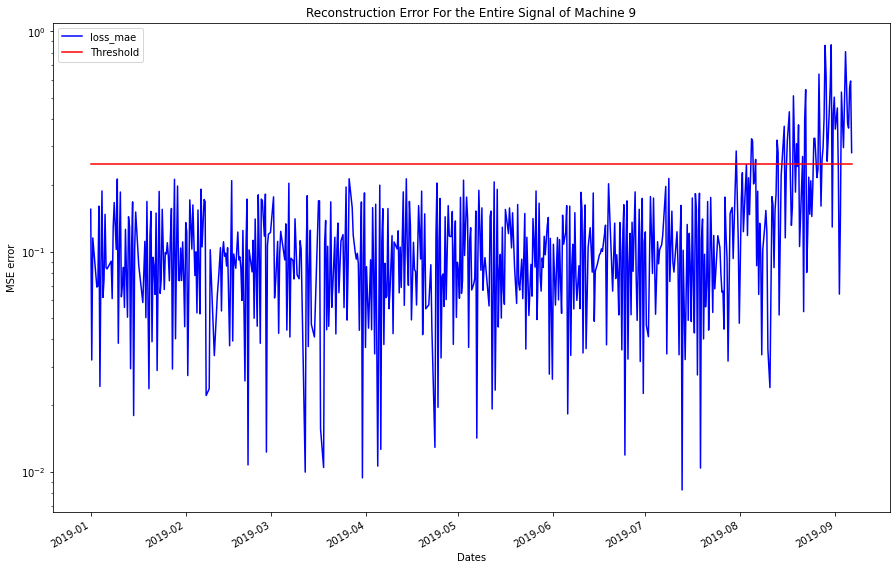

In [85]:
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0],X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train,columns=train_set.columns)
X_pred_train.index = train_set.index

scored_train= pd.DataFrame(index=train_set.index)
Xtrain= X_train.reshape(X_train.shape[0],X_train.shape[2])
scored_train['loss_mae']=np.mean(np.abs(X_pred_train-Xtrain),axis=1)
scored_train['Threshold'] = 0.25
scored_train['Anomaly']=scored_train['loss_mae']>scored_train['Threshold']
scored = pd.concat([scored_train,scored])

ax= scored.plot(logy=True,figsize=(15,10),color=['b','r'])
ax.set(xlabel='Dates',ylabel='MSE error', title='Reconstruction Error For the Entire Signal of Machine 9')
plt.show()

### Detecting Faulty Dates

When the reconstruction error goes above the defined threshold we can say that the machine is in the faulty stage. We just have to find out when the red line(threshold) is crossed by the reconstruction error.

In [86]:
times_of_faulty_stage=scored[scored['Anomaly']==True].index.tolist()
print('first five faulty stage days: ',times_of_faulty_stage[:5])

first five faulty stage days:  [Timestamp('2019-07-30 17:41:09.223074360'), Timestamp('2019-08-04 17:43:33.271090364'), Timestamp('2019-08-05 01:43:42.874291432'), Timestamp('2019-08-06 01:44:11.683894632'), Timestamp('2019-08-13 01:47:33.351117040')]


In [208]:
model.save('mymodel_machine_9.h5')
print('Model Saved')

Model Saved


In [87]:
# Helper function to find faulty dates using the trained model
def scored_plot(X_train,model,date_index):
    X_pred_train = model.predict(X_train)
    X_pred_train = X_pred_train.reshape(X_pred_train.shape[0],X_pred_train.shape[2])
    X_pred_train = pd.DataFrame(X_pred_train,columns=train_set.columns)
    X_pred_train.index = date_index

    scored_train= pd.DataFrame(index=date_index)
    Xtrain= X_train.reshape(X_train.shape[0],X_train.shape[2])
    scored_train['loss_mae']=np.mean(np.abs(X_pred_train-Xtrain),axis=1)
    scored_train['Threshold'] = 0.25
    scored_train['Anomaly']=scored_train['loss_mae']>scored_train['Threshold']
    #scored = pd.concat([scored_train,scored])
    times_of_faulty_stage=scored_train[scored_train['Anomaly']==True].index.tolist()
    print('first five faulty stage days: ',times_of_faulty_stage[:5])

    scored_train.plot(logy=True,figsize=(15,10),color=['b','r'])
    return times_of_faulty_stage
    

### Effectiveness of Autoencoder based approach

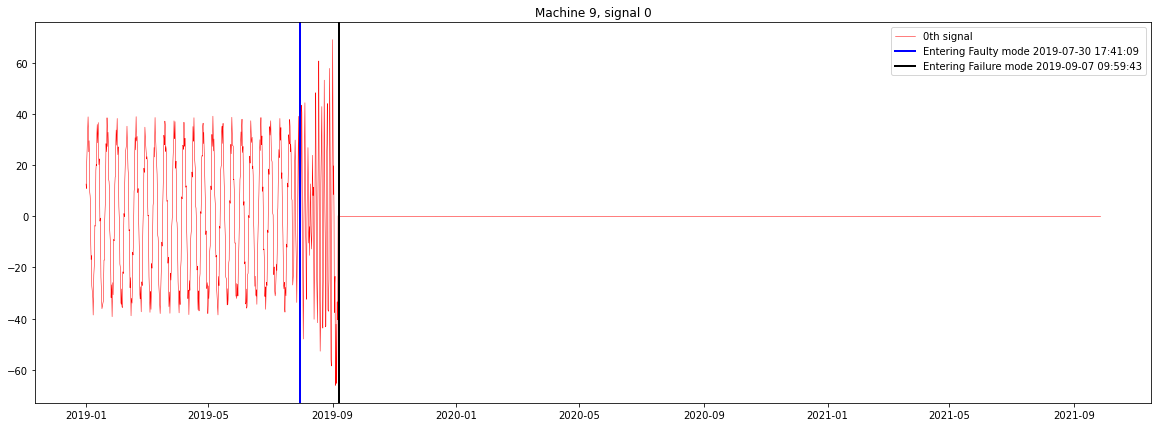

In [88]:
fig, ax = plt.subplots(1,1,figsize=(20,7))
dates= pd.to_datetime(data_z.index)
ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
ax.set(title='Machine 9, signal 0')
ax.plot(dates,data_z['0'],label='0th signal',color= 'red', animated=True,linewidth=0.5)
ax.axvline(times_of_faulty_stage[0],label='Entering Faulty mode '+ str(times_of_faulty_stage[0])[:19]
           ,c='blue',linewidth=2)
ax.axvline(times_of_failure[0],label='Entering Failure mode '+ str(times_of_failure[0])[:19],c='black',linewidth=2)
ax.legend()

Above plot is the signal 0 for machine 9. Blue line represents when autoencoder method predicted that the machine enters into the faulty mode. 

Black line is our prediction for when the Failed stage has reached.

By observing the graph it is clear that our method is working well for machine 9. We are able to detect the machine entering into faulty zone around **48** days before the machine fails. This gives ample amount of time to our ExampleCo engineers to take care of the machine before it breaks.


### Automating the above autoencoder model for different data file provided in the database


We can either repeat the same procedure for each machine or we can see if our model is able to generalize with similar signals from similar machine.

For that purpose we will try to use some other data file provided in the database machine 1. Let's perform the same data-preprocessing as did for the machine 9.

First five failure stage dates:  [Timestamp('2020-08-02 12:38:10.363454488'), Timestamp('2020-08-03 04:38:29.569856624'), Timestamp('2020-08-03 12:38:39.173057688'), Timestamp('2020-08-04 04:38:58.379459824'), Timestamp('2020-08-04 20:39:17.585861952')]
 
first five faulty stage days:  [Timestamp('2020-06-15 20:15:17.105701904'), Timestamp('2020-06-16 12:15:36.312104040'), Timestamp('2020-06-18 04:16:24.328109368'), Timestamp('2020-06-25 12:19:55.598532848'), Timestamp('2020-06-27 12:20:53.217739248')]


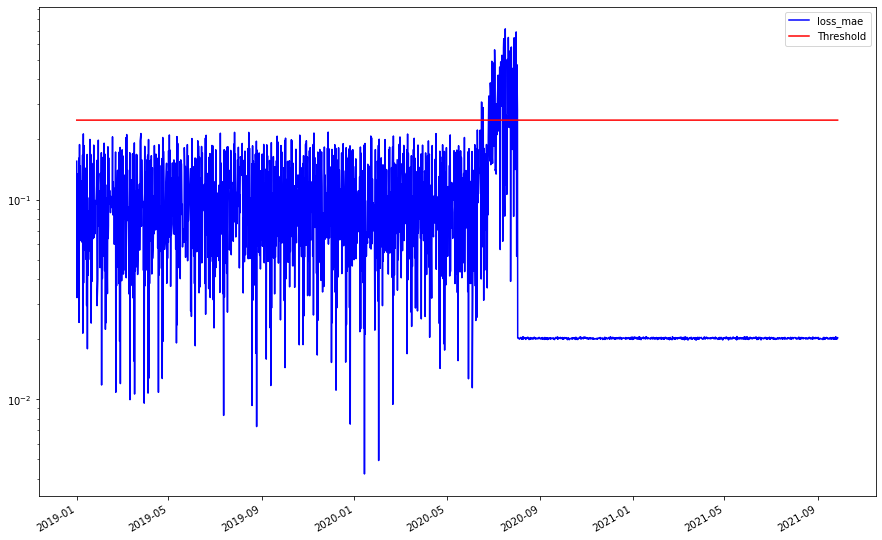

In [89]:
data1 = pd.read_csv('../input/challenge/exampleco_data/machine_1.csv',index_col=0) # reading the file

data1.index=pd.to_datetime(data1.index, format='%Y-%m-%d %H:%M:%S') #index in proper date format

data1 =remove_outliers(data1) # removing outliers

date_index = data1.index # setting the date index for plotting later

Failed_dates =failure_dates(data1) # Finding the failed dates

data2 =scaler.transform(data1) # using the same scaler function used while training the model

X = reshaped(data2) # reshaping the data for the model

print(' ') # printing empty line

Faulty_dates = scored_plot(X,model,date_index) # utilizing helper function to find faulty dates 

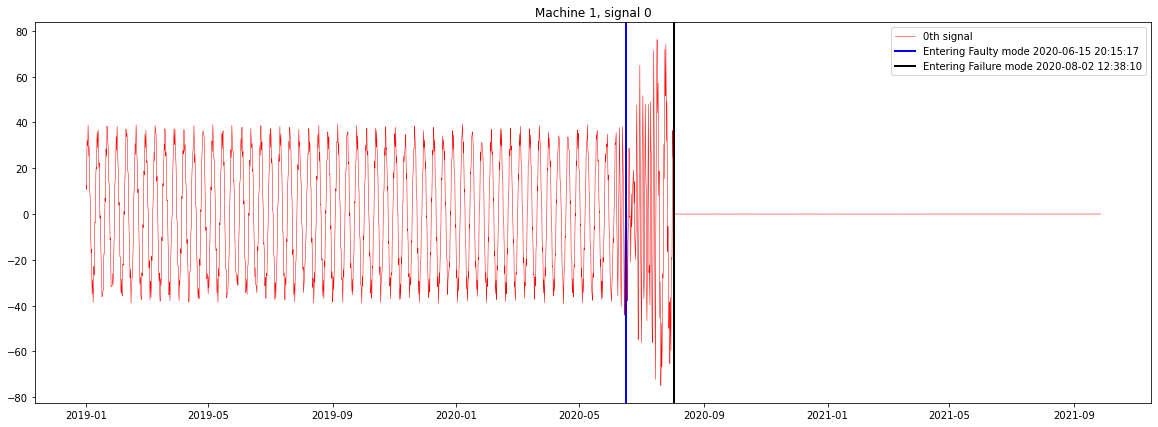

In [90]:
fig, ax = plt.subplots(1,1,figsize=(20,7))
dates= pd.to_datetime(data1.index)
ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
ax.set(title='Machine 1, signal 0')
ax.plot(dates,data1['0'],label='0th signal',color= 'red', animated=True,linewidth=0.5)
ax.axvline(Faulty_dates[0],label='Entering Faulty mode '+ str(Faulty_dates[0])[:19]
           ,c='blue',linewidth=2)
ax.axvline(Failed_dates[0],label='Entering Failure mode '+ str(Failed_dates[0])[:19],c='black',linewidth=2)
ax.legend()

From above plot it is visible that our autoencoder predicts the faulty stage when the machine sensor 0 starts giving irregular output. And we have also detected the failed stage accurately.  <br/>
Autoencoder detects faulty stage of machine 1 about **47** days before the machine completely fails.


### (2) classification based approach[](http://)

This approach is based on supervised learning, classification. Supervise learning needs example with labels to learn from. This method requires information about faulty and non-faulty stage as a form of a label.

Let's load the signal data which was filtered to have two stages: normal and faulty. Based on the graphs assign the dates as faulty or normal stage. We will be using the data from machine 9 to predict the faulty stage.
Here we will use gaussian binary classifier, even though it required conditional independence amongst the features it still is a powerful classification technique. 



In [91]:
data_c=pd.DataFrame(data_final)

The sensor readings are in the form of time-series. Sliding window of N measurements is used to calculate the feature vector for classification. With trying few values of window length N, N=20 gave a good result. 

Extracting, mean, variance, median, max, min features for the length of 20 window at each time, after first 20 observations.( Hence, removing the first 19 observations)

In [92]:
data_c['0_mean'] = data_c['0'].rolling(window=20).mean()
data_c['1_mean'] = data_c['1'].rolling(window=20).mean()
data_c['2_mean'] = data_c['2'].rolling(window=20).mean()
data_c['3_mean'] = data_c['3'].rolling(window=20).mean()
data_c['0_var'] = data_c['0'].rolling(window=20).var()
data_c['1_var'] = data_c['1'].rolling(window=20).var()
data_c['2_var'] = data_c['2'].rolling(window=20).var()
data_c['3_var'] = data_c['3'].rolling(window=20).var()
data_c['0_med'] = data_c['0'].rolling(window=20).median()
data_c['1_med'] = data_c['1'].rolling(window=20).median()
data_c['2_med'] = data_c['2'].rolling(window=20).median()
data_c['3_med'] = data_c['3'].rolling(window=20).median()
data_c['0_max'] = data_c['0'].rolling(window=20).max()
data_c['1_max'] = data_c['1'].rolling(window=20).max()
data_c['2_max'] = data_c['2'].rolling(window=20).max()
data_c['3_max'] = data_c['3'].rolling(window=20).max()
data_c['0_min'] = data_c['0'].rolling(window=20).min()
data_c['1_min'] = data_c['1'].rolling(window=20).min()
data_c['2_min'] = data_c['2'].rolling(window=20).min()
data_c['3_min'] = data_c['3'].rolling(window=20).min()




In [93]:
data_c = data_c.iloc[19:]

In [94]:
normal= data_c[:'2019-07-30 17:41:09.223074360']
faulty= data_c['2019-07-30 17:41:09.223074360':]

In [95]:
normal['label']= 0
faulty['label']=1
data_class = pd.concat([normal,faulty])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [96]:
y= data_class['label']
X= data_class.drop('label',axis=1)

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [98]:
print("In the test dataset Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (y_test != y_pred).sum()))

In the test dataset Number of mislabeled points out of a total 145 points : 2


In [99]:
y_pred_t = gnb.predict(X_train)

print("In the train dataset Number of mislabeled points out of a total %d points : %d"% (X_train.shape[0], (y_train != y_pred_t).sum()))

In the train dataset Number of mislabeled points out of a total 432 points : 4


In [100]:
from sklearn.metrics import accuracy_score
print('test_accuracy: ')
print(accuracy_score(y_test, y_pred))

test_accuracy: 
0.9862068965517241


In [101]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred))

Confusion Matrix: 
[[119   0]
 [  2  24]]


In [102]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       119
           1       1.00      0.92      0.96        26

    accuracy                           0.99       145
   macro avg       0.99      0.96      0.98       145
weighted avg       0.99      0.99      0.99       145



Plotting the ROC curve:

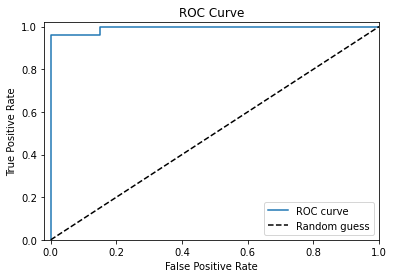

In [103]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline
y_pred_prob = gnb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")


In [104]:
from sklearn.metrics import roc_auc_score
print('AUC: ')
print(roc_auc_score(y_test, y_pred_prob))

AUC: 
0.9941822882999354


In [105]:
y_preds = gnb.predict(X)
X['y']=y_preds

Finding the faulty days according to the Naive Bayes algorithm for the machine 9

In [106]:
Faulty =X[X['y']==1].index.tolist()

In [107]:
print('first 15 faulty observations: ')
print(Faulty[:15])

first 15 faulty observations: 
[Timestamp('2019-08-03 01:42:45.255085028'), Timestamp('2019-08-03 09:42:54.858286096'), Timestamp('2019-08-03 17:43:04.461487164'), Timestamp('2019-08-04 01:43:14.064688232'), Timestamp('2019-08-04 09:43:23.667889296'), Timestamp('2019-08-04 17:43:33.271090364'), Timestamp('2019-08-05 01:43:42.874291432'), Timestamp('2019-08-05 09:43:52.477492500'), Timestamp('2019-08-05 17:44:02.080693564'), Timestamp('2019-08-06 01:44:11.683894632'), Timestamp('2019-08-06 09:44:21.287095700'), Timestamp('2019-08-06 17:44:30.890296768'), Timestamp('2019-08-07 01:44:40.493497832'), Timestamp('2019-08-07 09:44:50.096698900'), Timestamp('2019-08-07 17:44:59.699899968')]


### Effectiveness of Classification based approach

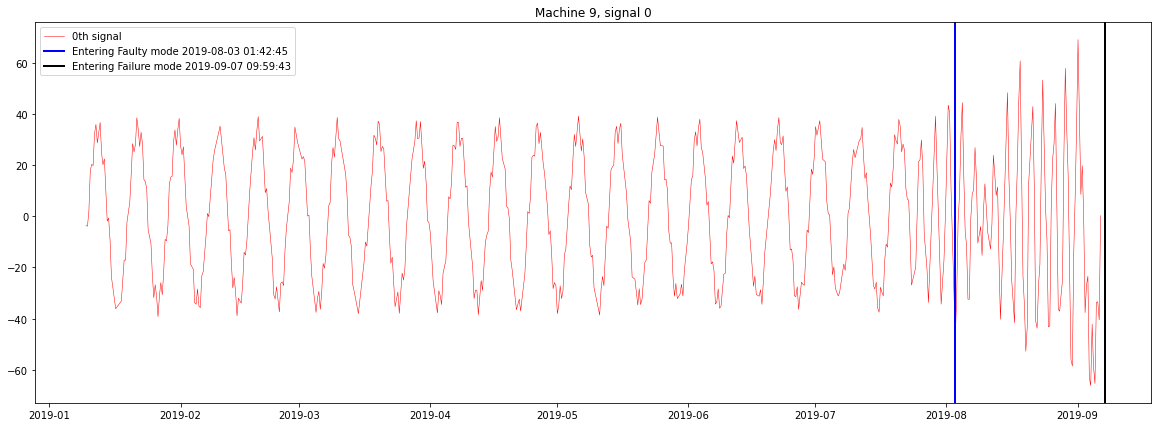

In [108]:
fig, ax = plt.subplots(1,1,figsize=(20,7))
dates= pd.to_datetime(data_c.index)
ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
ax.set(title='Machine 9, signal 0')
ax.plot(dates,data_c['0'],label='0th signal',color= 'red', animated=True,linewidth=0.5)
ax.axvline(Faulty[0],label='Entering Faulty mode '+ str(Faulty[0])[:19]
           ,c='blue',linewidth=2)
ax.axvline(times_of_failure[0],label='Entering Failure mode '+ str(times_of_failure[0])[:19],c='black',linewidth=2)
ax.legend()

Above plot is the signal 0 for machine 9. Blue line represents when Naive Bayes method predicted that the machine enters into the faulty mode.

Black line is our prediction for when the Failed stage has reached. 

By observing the graph it is clear that our method is working well for machine 9. We are able to detect the machine entering into faulty zone around **33** days before the machine fails. This gives ample amount of time to our ExampleCo engineers to take care of the machine before it breaks.


## Strength and limitations of Approaches

### (1) Characteristics of Autoencoder-based Approach

- This approach works on the principle that machine failure is preceded by its anomalous behaviour. In this particular case autoencoder detects anomalies. 
- Inputs for autoencoder are raw values from the signals, however we may extract feature values and use them as an input to the autoencoder. As a result we need to have historical data in order to train the autoencoder network.
- Model training took more time compared to classification approach but it was less than 2 minutes with CPU. 
- Autoencoder detects anomalous behaviors in unsupervised way, hence it does not just detect the faulty stage therefore in some rare cases when signal readings are not normal it may detect anomalous behaviour. Certain domain knowledge(such as how long it has been in this stage) will surely help to determine if it was just some anomalous behviour or it has entered the faulty stage.  
- It is safe to say if it is regulary being classified as faulty in recent readings it has entered faulty stage.
- Reconstruction error threshold can be easily adjusted based on importance of anomalous behavior detection vs how often the enginners at ExampleCo will have to assess the machine. This trade off can be easily controlled.
- From my observation, by testing with differnet machines provided in the dataset, this model easily generalized to give accurate results on the different machines. (make sure to use the same scaler function used while training the model).


### (2) Characteristics of Classification-based Approach

- First of all, the data have to be labeld in order to use this approach. In our case data was manually labeled by looking at the graphs of the signals. As our machines entered normal-faulty-failed stage in sequencial manner, it was easy to label the data. Faulty instances are labeled as 1, and normal as 0. If this label information is not available this approach can not be used.
- The signal readings are in the form of time series. Sliding window of N measurements was used to extract the feature vector for the classification. After few experimentation, N=20 gave good results for machine 9.
- This approach utlized simple features such as variance, mean, median, max, mean over the sliding window.
- Training with this method was almost instant.
- If the instance is classified as 1 then machine is evaluated as faulty.Certain domain knowledge(such as how long it has been in this stage) will surely help to determine if it was just some anomalous behviour (or misclassification) or it has entered the faulty stage.  
- It is safe to say if it is regulary being classified as faulty in recent readings it has entered faulty stage.
- The results can be obtained in terms of probability and then the threshold can be adjusted in order to control the trade off between the importance of anomalous behavior detection vs how often the enginners at ExampleCo will have to assess the machine.

## Future work and approaches:  

(1) Future work for Autoencoder Approach:
- Trying out different autoencoder model architectures to see how it affects the results. 
- Trying out different evaluation metrics, and optimizer.
- Testing out the generalization of the technique in more systematic manner. 
- Organizing code in OOP manner to create a python package out of it.



(2) Future work for Classification Approach:
- Trying out weighted averages for the sliding window while extracting the features.
- Trying out advanced feature extraction techniques such as fourier, wavelet coefficients.
- Using differnet classification models such as trees, neural networks to compare the performances of models and select the best performer.
- Testing out the generalization of the method with differnet machines. 
 
(3) Trying Time-Series Approach:
- This method will also assume that the malfunction of the machine is preceded by an abnormal behaviour. 
- Our signal readings are time-series with significant regular patterns in normal mode, therefore we can use ARIMA model to obtain predictions. ARIMA model is general regressive model for time-series modeling. 
- Predicted values of the time-series will be compared with the actual values and if the difference is higher than a certain threshold measurements could be marked as faulty.

